# Voting Analysis

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import os
import statsmodels.api as sm
from datetime import datetime
from scipy import stats

In [3]:
cwd = os.getcwd()
date_format = "%Y-%m-%d"
TORNADO_PATH = os.path.join(cwd, "..", "data/tornadoes/US_tornadoes_2000_2022.csv")
TORNADO_SHAPEFILE = os.path.join(cwd, "..", "data/geographic/US_tornadoes_1950_2022/US_tornadoes_1950_2022.shp")
COUNTIES_PATH = os.path.join(cwd, "..", "data/counties/2018_counties.csv")
COUNTIES_SHAPEFILE = os.path.join(cwd, "..", "data/geographic/cb_2018_us_county_5m/cb_2018_us_county_5m.shp")
INTERSECTION_PATH = os.path.join(cwd, "..", "data/tornado_county_intersections.csv")
PERCENT_PATH = os.path.join(cwd, "..", "data/tornadoes_and_counties_new.csv")
RESULTS_PATH = os.path.join(cwd, "..", "data/results_2000s.csv")

# Naive Comparison

In [22]:
def getCountyVoteSet_FlatCount(data_vote,data_tornado,year):
    output = np.array([[0.0,0]]* len(data_vote))
    
    i = 0
    for row in data_vote.index:
        
        filter1 = data_tornado.loc[data_tornado["GEOID"] == data_vote["fips"][row]]
        filter2 = filter1.loc[filter1["yr"].isin(range(year-4,year+1))]
        filter2 = filter2.loc[filter2["mag"]>0]
        output[i,1] = len(filter2)
        output[i,0] = data_vote[str(year)][row]
        # print(i)
        i+=1
    
    return output

def getCountyVoteSet_CostAgg(data_vote,data_tornado,year):
    output = np.array([[0.0,0]]* len(data_vote))
    
    i = 0
    for row in data_vote.index:
        
        filter1 = data_tornado.loc[data_tornado["GEOID"] == data_vote["fips"][row]]
        filter2 = filter1.loc[filter1["yr"].isin(range(year-4,year+1))]
        totalCost = sum(filter2["loss"])
        output[i,1] = totalCost
        output[i,0] = data_vote[str(year)][row]
        # print(i)
        i+=1
    
    return output

def getCountyVoteSet_Casualties(data_vote,data_tornado,year):
    output = np.array([[0.0,0]]* len(data_vote))
    
    i = 0
    for row in data_vote.index:
        
        filter1 = data_tornado.loc[data_tornado["GEOID"] == data_vote["fips"][row]]
        filter2 = filter1.loc[filter1["yr"].isin(range(year-4,year+1))]
        totalCost = sum(filter2["inj"]) + sum(filter2["fat"])
        output[i,1] = totalCost
        output[i,0] = data_vote[str(year)][row]
        # print(i)
        i+=1
    
    return output

    
    


/var/folders/9t/8dttwx0522nbvhd7n1_m1lwh0000gq/T/ipykernel_14971/124288325.py:11: RuntimeWarning: divide by zero encountered in log
  cas_log = np.log(scatters[:,1])


2012
2016
2020
2012
2016
2020


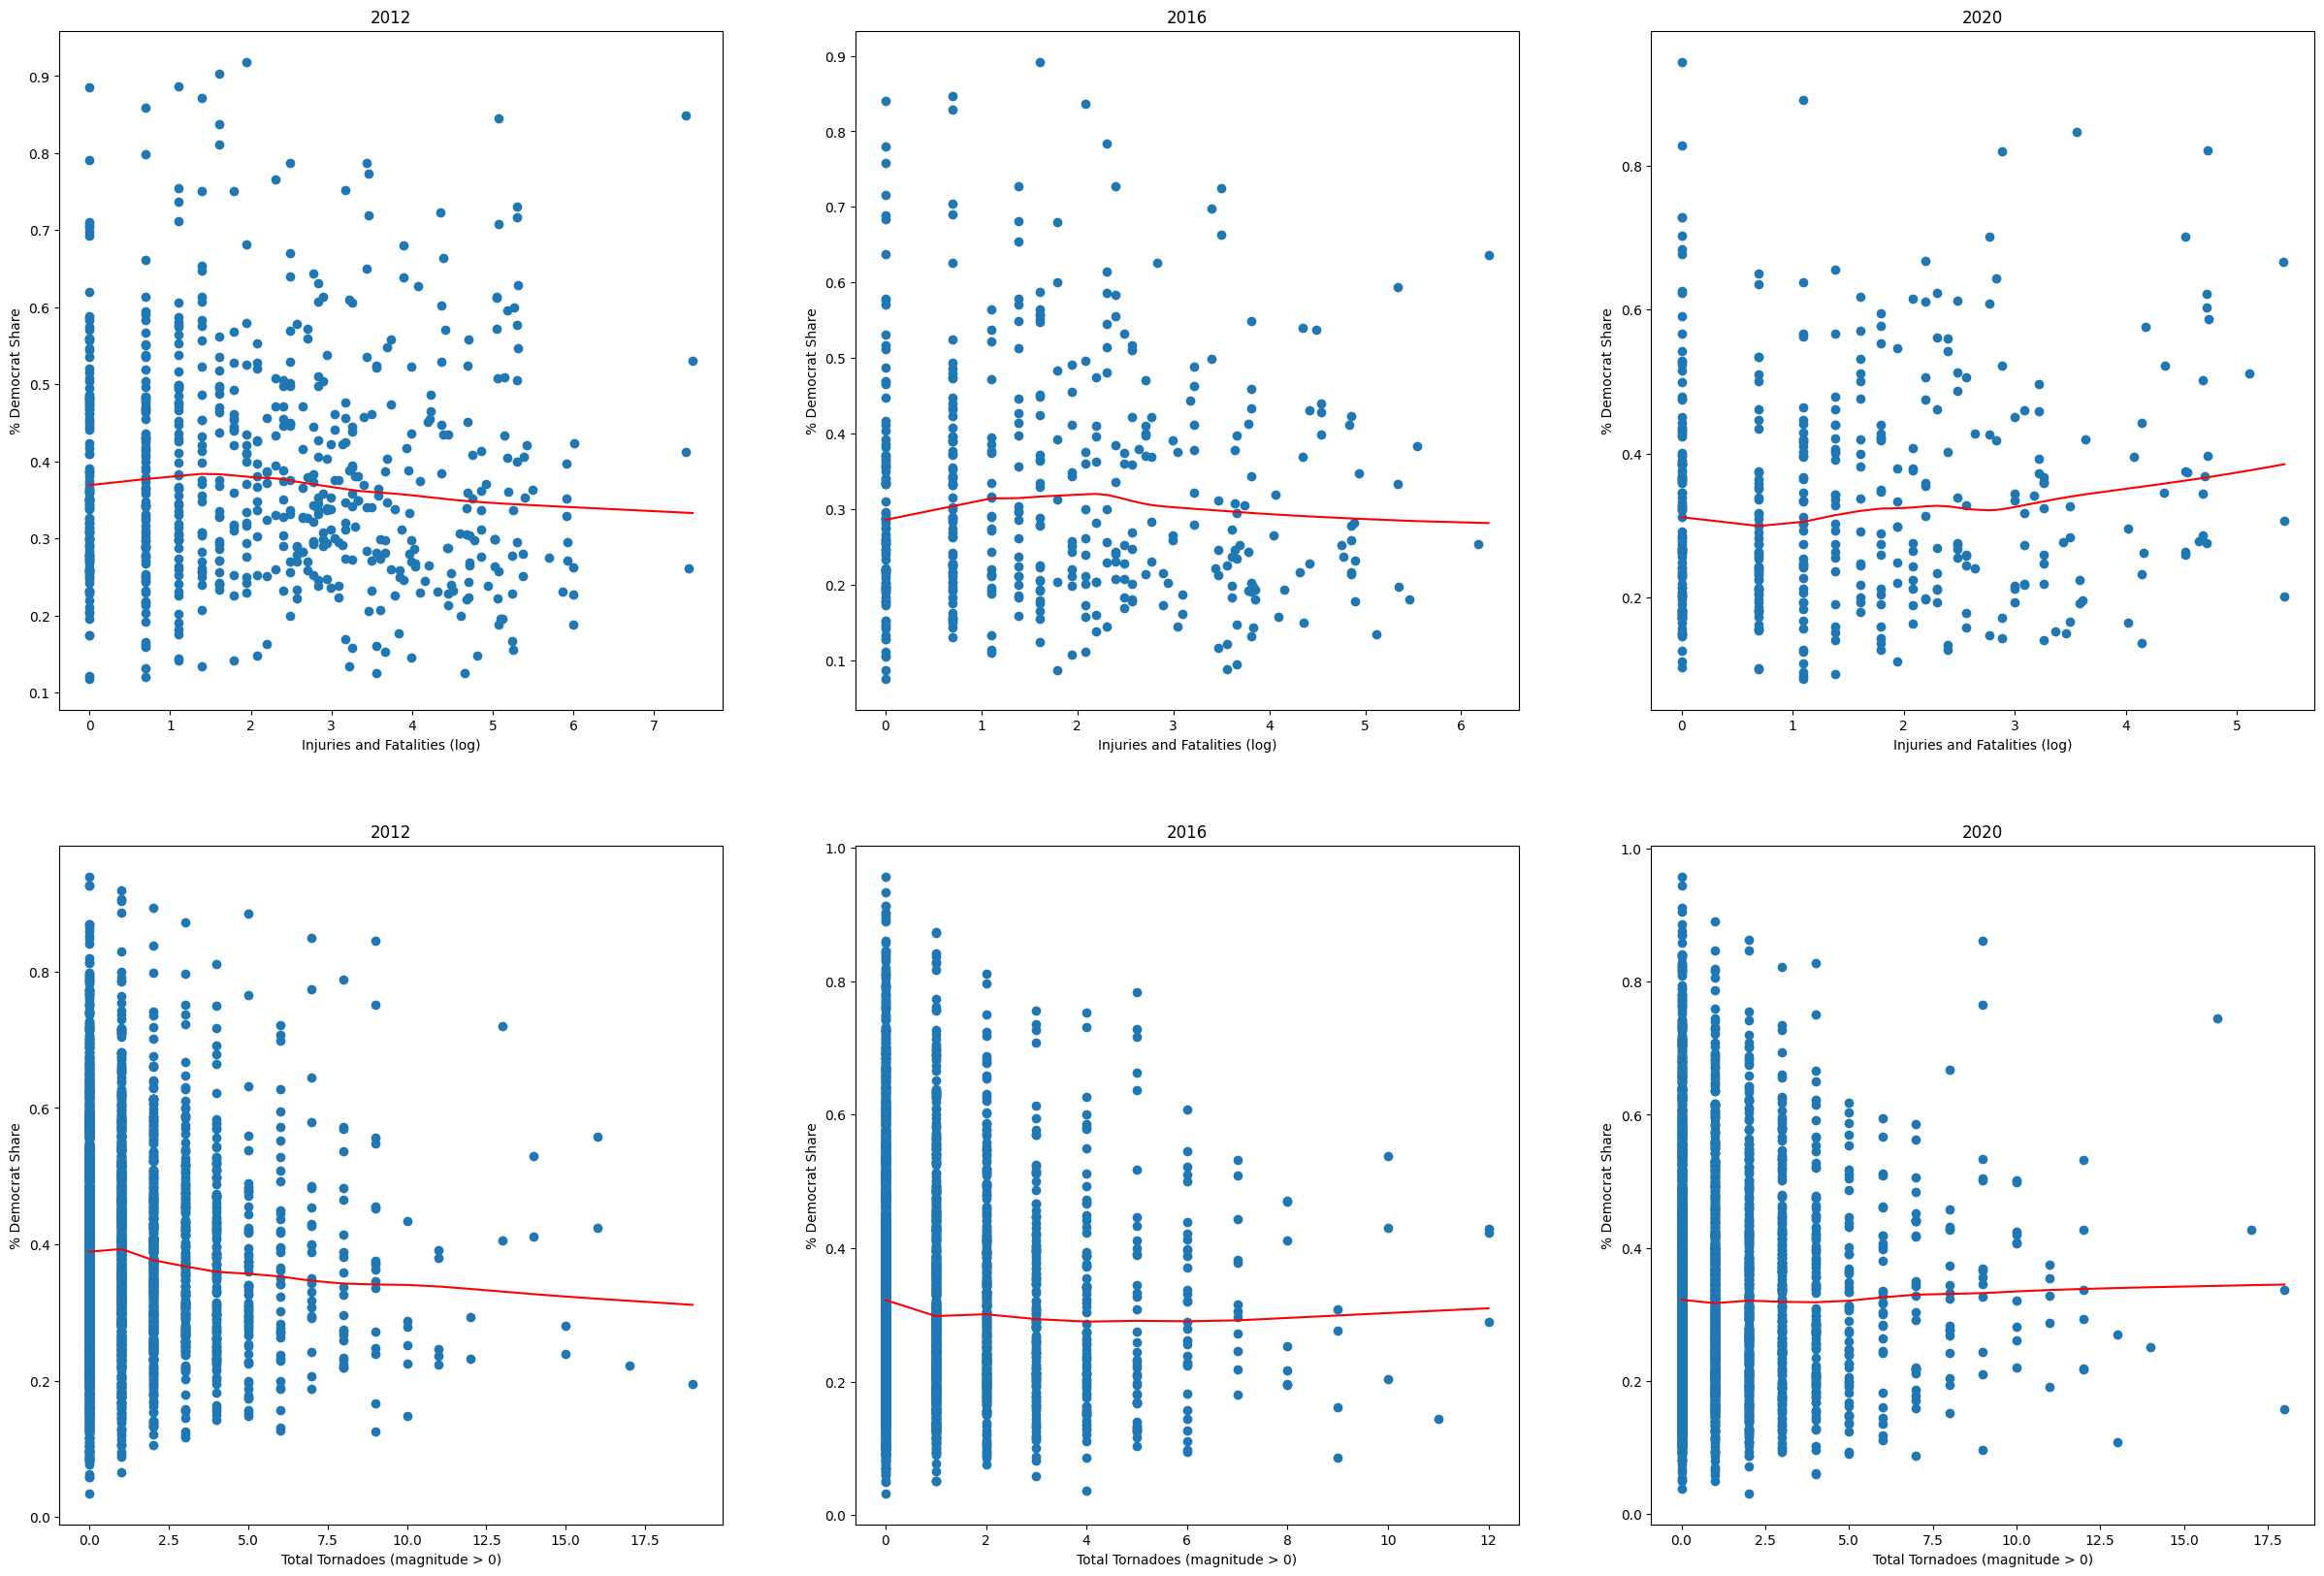

In [25]:
data_tornado = pd.read_csv(INTERSECTION_PATH)
data_voting = pd.read_csv(RESULTS_PATH)

# plt.figure(figsize=(30,18))
fig, axs = plt.subplots(2,3, figsize=(30, 20))
i = 0

for year in range(2012, 2021, 4):
    dist_Dem = data_voting.loc[data_voting[str(year)].notnull()]
    scatters = getCountyVoteSet_Casualties(dist_Dem,data_tornado,year)
    cas_log = np.log(scatters[:,1])
    lowess = sm.nonparametric.lowess(scatters[:,0],cas_log)
    print(year)
    
    axs[0,i].scatter(cas_log,scatters[:,0])
    axs[0,i].set_title(f"{year}")
    axs[0,i].set_ylabel("% Democrat Share")
    axs[0,i].plot(lowess[:,0],lowess[:,1],color="red")
    axs[0,i].set_xlabel("Injuries and Fatalities (log)")
    i+=1
# plt.show()
    
# i=0   
# for year in range(2004, 2021, 4):
#     dist_Dem = data_voting.loc[data_voting[str(year)].notnull()]
    
#     scatters = getCountyVoteSet_CostAgg(dist_Dem,data_tornado,year)
#     print(year)
#     axs[1,i].scatter(scatters[:,1],scatters[:,0])
#     axs[1,i].set_title(f"{year}")
#     axs[1,i].set_ylabel("% Democrat Share")
#     axs[1,i].set_xlabel("Total Monetary Loss")
#     i+=1

i=0    
for year in range(2012, 2021, 4):
    dist_Dem = data_voting.loc[data_voting[str(year)].notnull()]
    scatters = getCountyVoteSet_FlatCount(dist_Dem,data_tornado,year)
    lowess = sm.nonparametric.lowess(scatters[:,0],scatters[:,1])
    print(year)
    axs[1,i].scatter(scatters[:,1],scatters[:,0])
    axs[1,i].plot(lowess[:,0],lowess[:,1],color="red")
    axs[1,i].set_title(f"{year}")
    axs[1,i].set_ylabel("% Democrat Share")
    axs[1,i].set_xlabel("Total Tornadoes (magnitude > 0)")
    i+=1
plt.show()
    



# Synthetic Control

In [60]:


def getTornadoSet_Cas(data_tornado, min_cas):

    filter1 = data_tornado[(data_tornado["fat"] + data_tornado["inj"]) * data_tornado["pct_of_tornado"]/100.0 >= min_cas]
    filter2 = filter1[filter1["yr"]>=2000]
    # print(filter2[["om","date","st","fat","inj","GEOID","pct_of_tornado"]])
    
    return filter2



# data_tornado = pd.read_csv(TORNADO_PATH)
data_tornado = pd.read_csv(PERCENT_PATH)
data_voting = pd.read_csv(RESULTS_PATH)
tornadoSet = getTornadoSet_Cas(data_tornado,100)
print(tornadoSet[["om","date","st","fat","inj","GEOID","pct_of_tornado"]])
print(len(tornadoSet))


           om        date  st  fat   inj  GEOID  pct_of_tornado
46328     600  2000-12-16  AL   11   144   1125         100.000
46385     634  2000-02-13  GA   11   175  13205         100.000
47332    1050  2000-09-20  OH    1   100  39057         100.000
49923      47  2003-03-20  GA    6   200  13205          84.751
53533    1253  2005-11-06  KY   24   238  18173          50.309
55402     299  2006-04-07  TN    7   128  47165          83.843
57921     541  2008-04-28  VA    0   200  51800          67.021
58002     666  2008-05-10  OK   21   350  40115          30.463
58004     666  2008-05-10  OK   21   350  29145          40.670
63000  314625  2011-04-27  AL   64  1500   1125          50.371
63001  314625  2011-04-27  AL   64  1500   1073          40.887
63002  314625  2011-04-27  AL   64  1500   1063           8.713
63069  305268  2011-04-27  GA   20   335  47011          44.850
63395  296616  2011-05-22  MO  158  1150  29145         100.000
63461  315837  2011-05-24  OK    9   181

In [59]:
def nextElection(year):
    """
    Find next election year after the current year
    Will need to filter out tornadoes that occur between voting day and inauguration
    """
    
    yearSet = {2004,2008,2014,2016,2020}
    curYear = int(year)
    while not curYear in yearSet:
        curYear+=1
    return curYear
     
def find_synth(data_tornado, data_vote, county, election_year, tornado_year):
    """
    Find a set of counties that can act as a synthetic control for a county, having similar stats, and being far enough away.
    Omit the year that is being observed.
    """
    id_set = set(data_vote["fips"])
    
    controlSet = set()
    
    for county2 in id_set:
        if not farEnough(id,county, 10):
            continue
        if not testVoteSimilarity(data_vote, county, county2, election_year, 0.1):
            continue
        if not testTornadoSimilarity(data_tornado, county, county2, tornado_year, 0.1):
            continue
        controlSet.add(county2)
    
    return controlSet


def testTornadoSimilarity(data_tornado, county1, county2, capYear, significance):
    """
    Test if the tornado data between two counties is similar prior to the "treatment" year 
    Only uses the frequency of tornadoes as a baseline
    """
    
    County1Tornadoes = data_tornado[data_tornado["GEOID"]==county1]
    County2Tornadoes = data_tornado[data_tornado["GEOID"]==county2]
    
    County1Set = []
    County2Set = []
    
    for currentYear in range(1999,capYear):
        County1Set.append(len(County1Tornadoes[County1Tornadoes["yr"] == str(currentYear)]))
        County2Set.append(len(County2Tornadoes[County2Tornadoes["yr"] == str(currentYear)]))
        
    t_val, p_val = stats.ttest_ind(County1Set,County2Set)
    
    return t_val <= significance

def testVoteSimilarity(data_voting, county1, county2, capYear, significance):
    """
    Test if the voter share data between two counties is similar prior to the "treatment" year 
    """
    
    County1Votes = data_voting[data_voting["fips"]==county1]
    County2Votes = data_voting[data_voting["fips"]==county2]
    County1Set = []
    County2Set = []
    for currentYear in range(2004, capYear, 4):
        County1Set.append(County1Votes[str(currentYear)][0])
        County2Set.append(County2Votes[str(currentYear)][0])
    
    t_val, p_val = stats.ttest_ind(County1Set,County2Set)
    
    return t_val <= significance

def farEnough(county1,county2, min_distance):
    """ 
    Return True if two counties are far enough to be considered independent
    """
    return True
    
    
    

In [ ]:
def findChangeValue(data_tornado, data_vote, county_id, tornado_id, controlSet, year_range = 4):
    """
    Compare new value at election Year between county and its synthetic control set
    """
    pass

# Specify County fips and tornado om for each entry
countyTestSet = [
    [13205,47, "2003-03-20"]
]
def run_synthetic_control(data_tornado, data_vote, testSet):
    """ 
    Run synthetic control for each county in countyTestSet and aggregate their results
    """
    for idSet in testSet:
        tornadoYear = data_tornado[data_tornado["om"]==idSet[1]]["yr"][0]
        electionYear = nextElection(tornadoYear)
        synth_set = find_synth(data_tornado,data_vote,idSet[0],electionYear,tornadoYear)
        delta = findChangeValue(data_tornado, data_vote, idSet[0], idSet[1], synth_set)
        
        
    
    

# New Synthetic Control

In [4]:
from SyntheticControlMethods import Synth, DiffSynth

cwd = os.getcwd()
date_format = "%Y-%m-%d"
TORNADO_PATH = os.path.join(cwd, "..", "data/tornadoes/US_tornadoes_2000_2022.csv")
TORNADO_SHAPEFILE = os.path.join(cwd, "..", "data/geographic/US_tornadoes_1950_2022/US_tornadoes_1950_2022.shp")
COUNTIES_PATH = os.path.join(cwd, "..", "data/counties/2018_counties.csv")
COUNTIES_SHAPEFILE = os.path.join(cwd, "..", "data/geographic/cb_2018_us_county_5m/cb_2018_us_county_5m.shp")
INTERSECTION_PATH = os.path.join(cwd, "..", "data/tornado_county_intersections.csv")
PERCENT_PATH = os.path.join(cwd, "..", "data/tornadoes_and_counties_new.csv")
RESULTS_PATH = os.path.join(cwd, "..", "data/results_2000s.csv")

In [9]:
# Specify County fips and tornado om for each entry
countyTestSet = [
    [13205,47,2003]
]
def run_synthetic_control(testSet):
    """ 
    Run synthetic control for each county in countyTestSet and aggregate their results
    """
    data_tornado = pd.read_csv(PERCENT_PATH)
    data_voting = pd.read_csv(RESULTS_PATH)
    for idSet in testSet:
        sc = Synth(data_tornado, "fat", "GEOID", "yr",idSet[0],idSet[2])
        sc.plot(["original", "pointwise", "cumulative"], treated_label="West Germany", 
            synth_label="Synthetic West Germany", treatment_label="German Reunification")

run_synthetic_control(countyTestSet)
        

ValueError: cannot reshape array of size 0 into shape (73,1)